In [15]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import glob

from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['text.usetex'] = True
colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
from matplotlib.gridspec import GridSpec

from scipy import interpolate
from scipy.special import expit
from matplotlib import cm

In [16]:
import time
s = time.time()

# print out time in format d:h:m:s
def time_format(t):
    secs = int(t % 60)
    t = (t - secs)/60
    mins = int(t % 60)
    t = (t - mins)/60
    hours = int(t % 24)
    t = (t - hours)/24
    days = int(t)
  
    def to_string(num):
        if (int(num)<10):
            return '0%d:' %num
        else:
            return '%d:' %num
    
    def day_hr_str(num):
        if (int(num)==0):
            return ''
        else:
            return to_string(num)

    time_str = day_hr_str(days) + day_hr_str(hours) + to_string(mins) + to_string(secs)
    return time_str[:-1]

In [17]:
class bubble:
    
    def __init__(self,Nk,pars):
        
        self.Nk = Nk
        self.pars = pars
        self.kvec = np.linspace(0,np.pi,self.Nk,endpoint=True)
        self.init_disp()
        self.multiplicity = 2.0
        
######################################################
    # dispersion on square lattice with tight binding hopping amplitudes
    def dispersion(self,k):
        return ( -2.*self.pars['t'] * ( np.cos(k[0]) + np.cos(k[1]) )
                 -4.*self.pars['tp'] * np.cos(k[0]) * np.cos(k[1])
                 -2.*self.pars['ts'] * ( np.cos(2.*k[0]) + np.cos(2.*k[1]) ) )
    
######################################################
    # symmetrize an object with a 2D base manifold. Here: bubble in 2D momentum space
    def __symmetrize(self,OBJ,pl=1):
        if(pl!=1):
            pl=0
        
        OBJ = np.concatenate((OBJ[::-1,:],OBJ[1:,:]),axis=0)[pl:,:]
        OBJ = np.concatenate((OBJ[:,::-1],OBJ[:,1:]),axis=1)[:,pl:]
        return OBJ
        
######################################################
    # generate discrete values for dispersion and momentum vectors
    def init_disp(self):
        self.eps = np.zeros((self.Nk,self.Nk),dtype=float)
        
        for ix,kx in enumerate(self.kvec):
            for iy,ky in enumerate(self.kvec):
                self.eps[ix,iy] = self.dispersion([kx,ky])
                
        self.kvec = np.concatenate((-self.kvec[::-1],self.kvec[1:]))[1:]
        self.eps = self.__symmetrize(self.eps)
    
######################################################
    # step function
    def theta(self,x):
        return 0.5 + 0.5 * np.sign(x)
    
######################################################
    # fermi function
    def fermi_f(self,x,T=0):
        if (T==0):
            return self.theta(-x)
        else:
            return expit(-x/T)
######################################################
    # calculate bubble, do k space integral as Einstein sum (np.einsum)
    def calc_bubble(self,mu,T=0,Np=-1,delt=1e-5):
        
        if (Np==-1):
            Np = self.Nk
            
        rp = self.Nk // Np
        rp = int(abs(rp))
        
        self.qvec   = np.linspace(0,np.pi,self.Nk//rp,endpoint=True)
        self.bubble = np.zeros((self.Nk//rp,self.Nk//rp),dtype=float)
        
        print('bubble shape=', self.bubble.shape)
        
        time_0 = time.time()
        
        #iterate over possible q values
        for ix,qx in enumerate(self.qvec):
            for iy,qy in enumerate(self.qvec):
                
                xi1 = self.eps - mu
                xi2 = np.roll(np.roll(self.eps,rp*ix,axis=1),rp*iy,axis=0) - mu
                f1 = self.fermi_f(xi1,T)
                f2 = self.fermi_f(xi2 + delt ,T)
                bub_int = - self.multiplicity*( f1 - f2 ) / ( xi1 - (xi2+delt) )
                
                self.bubble[ix,iy] = 1.0/(self.Nk)**2 * np.einsum('ij->',bub_int)

            # show progress
            if ( ix%int(self.qvec.shape[0]//20)==0  ):
                t = time.time() - time_0
                print(time_format(t), '%.2f' %(100.*float(ix)/self.bubble.shape[0]) )
        
        self.bubble = self.__symmetrize(self.bubble,pl=0)
        self.qvec = np.concatenate((-self.qvec[::-1],self.qvec[1:]))

In [18]:
#smooth results: high value of Np required
#Np = 500
#quick calculation: low value of Np
Np = 50

In [19]:
pps = {'t':1, 'tp': -0.35, 'ts':0}
BUB = bubble(Np,pps)
print(BUB.eps.shape,BUB.kvec.shape[0]**2)

(98, 98) 9604


In [20]:
# chemical potential to guarantee flat hot spots
def mu4(tp):
    return 8*(tp-2*tp**3)

mu = mu4(pps['tp'])
print(mu)

Pi0 = BUB.calc_bubble(mu=mu,T=5e-3,delt=1e-7,Np=Np)

print('\n',BUB.bubble.shape,BUB.qvec.shape)

-2.114
bubble shape= (50, 50)
00:00 0.00
00:00 4.00
00:00 8.00
00:00 12.00
00:00 16.00
00:00 20.00
00:00 24.00
00:00 28.00
00:00 32.00
00:00 36.00
00:00 40.00
00:00 44.00
00:00 48.00
00:00 52.00
00:00 56.00
00:00 60.00
00:00 64.00
00:00 68.00
00:00 72.00
00:00 76.00
00:00 80.00
00:00 84.00
00:00 88.00
00:00 92.00
00:00 96.00

 (99, 99) (99,)


In [7]:
# we can optionally save data to a .h5 file
# this is reasonable for a calculation with high resolution that takes a long time
PL, grid = BUB.bubble,BUB.qvec
h = h5py.File("tightbinding_susceptibility.h5",'w')
h.create_dataset("grid",data=grid)
h.create_dataset("data",data=PL)
h.close()

In [8]:
# essential data on file: momentum space grid and bare susceptibility values
file = h5py.File("tightbinding_susceptibility.h5",'r')
grid = file['grid']
PL = file['data']

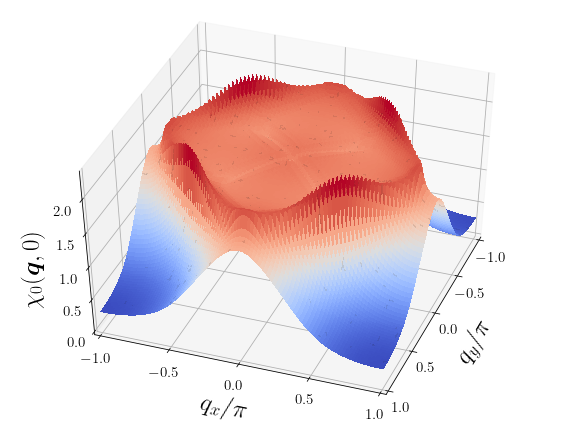

In [9]:
#plot the bare susceptibility in momentum space as 3D surface plot
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

X,Y = np.meshgrid(grid,grid)

plt.tight_layout()
ax.plot_surface(X/np.pi,Y/np.pi, PL, cmap=cm.coolwarm,antialiased=False,rcount=500,ccount=500,
               edgecolor=(0.1, 0.1, 0.1, 0.1),linewidth=0.00003)
                
ax.azim = 20 
ax.dist = 10
ax.elev = 45
ax.zaxis.set_rotate_label(False)

ax.set_xlabel(r'$q_y/\pi$',fontsize=25,labelpad=15)
ax.set_ylabel(r'$q_x/\pi$',fontsize=25,labelpad=15)
ax.set_zlabel(r'$\chi_0(\boldsymbol{q},0)$',fontsize=25,rotation=90,labelpad=10)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
zlim=ax.get_zlim()
ax.set_zlim(0,zlim[1])

ax.tick_params(labelsize=15)
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_yticks([-1,-0.5,0,0.5,1])

#save figure as png:
#plt.savefig('staticSusceptibilityThesis.png',dpi=300,bbox_inches="tight")